### Part 1: single $S = 1/2$ particle ###

Spin degree of freedom of spin-1/2 particles is represented by the traceless Hermitian matrixes $\hat \sigma_x$, $\hat \sigma_y$, $\hat \sigma_z$ introduced by Wolfgang Pauli (who was a professor at ETH Zürich, by the way!):

In [3]:
import numpy as np

s_x = np.array([
    [0, 1],
    [1, 0]
])

s_y = np.array([
    [0, -1.0j],
    [1.0j, 0]
])

s_z = np.array([
    [1, 0],
    [0j, -1]
])

# check tracelessness
assert np.trace(s_x) == 0
assert np.trace(s_y) == 0
assert np.trace(s_z) == 0

# check Hermicity
assert np.allclose(s_x.conj().T, s_x)
assert np.allclose(s_y.conj().T, s_y)
assert np.allclose(s_z.conj().T, s_z)

Any quantum mechanical problem consists of two main parts:
1.  Construct the Hamiltonian of the problem (i.e., write down the **matrix**),
2.  Find its energies and eigenstates (i.e., find the matrix's **eigenvalues** and **eigenvectors**).

Quantum mechanics and linear algebra _are very closely related_.


The simplest possible Hamiltonian in quantum mechanics describes spin-1/2 particle in magnetic field: $$\hat H = -\gamma \mathbf{h} \cdot \mathbf{\hat S} = -\frac{1}{2} \gamma \hbar \mathbf{h} \cdot \boldsymbol{\hat \sigma} = -\frac{1}{2} \gamma \hbar \left(h_x \hat \sigma_x + h_y \hat \sigma_y + h_z \hat \sigma_z\right),$$

where $\gamma$ is the particle's gyromagnetic ratio (equals 2 for an electron not accounting for the quantum field theory corrections) and $\hbar$ is the Plank constant. In the following, we will omit these constants.

Let us point the magnetic field in the $z$--direction. The Hamiltonian then reads simply:
$$\hat H = -h_z \hat \sigma_z.$$

In [ ]:
h_z = 1.
H = -h_z * s_z

Now, as the Hamiltonian is constructed, we will find its energies and eigenstates:

In [ ]:
assert np.allclose(H.conj().T, H) # always check in advance that the Hamiltonian is hermitean

energies, eigenstates = np.linalg.eigh(H)  # we use eigh since Hamiltonian is hermitean by definition

print(energies)
print(eigenstates.T)  # we transpose

assert np.allclose(energies, energies.real)  # note that hermitean matrix can only have real eigenvalues

assert np.isclose(np.dot(eigenstates[:, 0].T.conj(), \
                         eigenstates[:, 1]), 0.0)  # check that the eigenstates are orthogonal

Quite expectedly, the Hamiltonian has two energy levels: $\pm h_z$ and the corresponding eigenstates $$|\uparrow \rangle= \begin{pmatrix} 1 \\ 0 \end{pmatrix},\;|\downarrow\rangle = \begin{pmatrix} 0 \\ 1 \end{pmatrix}.$$

So, the system energy is lowered by $h_z$ if the spin points up, in the direction of the magnetic field, or it is raised by $h_z$ otherwise.

If a quantum system interacts with a finite-temperature reservoir, its properties are described by the **density matrix**:

$$\hat \rho = \frac{e^{-\beta \hat H}}{\text{Tr}\, e^{-\beta \hat H}},$$

where $\beta = 1/T$ is the inverse temperature of the system. The density matrix can be computed either directly by matrix exponentiation or more cleverly by using the already obtained energies and eigenstates.

To do the former, let us recall that any diagonalizable matrix can be represented in terms of its eigenvalues and eigenvectors as
$$\hat H = \sum\limits_i E_i |i \rangle \langle i |,$$
where $E_i$ is the $i^\text{th}$ eigenvalue (energy) and $|i \rangle \langle i|$ is the _outer product_ of the $i^\text{th}$ eigenvector (eigenstate) with itself.

Then the density matrix reads
$$\hat \rho = \frac{\sum\limits_i e^{-\beta E_i} |i \rangle \langle i|}{\sum\limits_i e^{-\beta E_i}} = \frac{1}{Z} \sum\limits_i e^{-\beta E_i} |i \rangle \langle i|.$$
    
Here we denoted the denominator as the _partition function_ $Z$. Let us now check that this indeed works:

In [ ]:
import scipy.linalg

def rho_direct(beta):
    return scipy.linalg.expm(-beta * H) / np.trace(scipy.linalg.expm(-beta * H))

def rho_energies(beta):
    energies, eigenstates = np.linalg.eigh(H)
    Z = np.sum(np.exp(-energies * beta))

    return np.einsum('i,ji,ki->jk', np.exp(-energies * beta), eigenstates, eigenstates) / Z
    # this einsum operation is equivalent to a sum of outer products of individual eigenstates

for beta in np.linspace(0., 1., 100):
    assert np.allclose(rho_direct(beta), rho_energies(beta))

Given the density matrix (computed either way), one can obtain the expectation value of any _observable_ given by the Hermitian operator $\hat A$ as:
$$ \langle \hat A \rangle = \text{Tr}\, \hat \rho \hat A.$$

In the following, let us define $\hat M_z = \hat \sigma_z$ as the operator corresponding to the total magnetization in the $z$-direction, with expectation value $M_z = \text{Tr}\, \hat \rho \hat M_z = \text{Tr}\, \hat \rho \hat \sigma_z$, and $\hat M_y = \hat \sigma_y$ as the operator corresponding to the total magnetization in the $y$-direction $M_y = \text{Tr}\, \hat \rho \hat M_y = \text{Tr}\, \hat \rho \hat \sigma_y$

It is easy to see that the expectation value of the operator $\hat M_z$ given by $M_z = \text{Tr}\, \hat \rho \hat M_z = \text{Tr}\, \hat \rho \hat \sigma_z$ simply finds the _difference_ between the probabilities for the spin to point up and down.

In [ ]:
def M_z(beta):
    return np.trace(rho_energies(beta).dot(s_z))

def M_y(beta):
    return np.trace(rho_energies(beta).dot(s_y))

betas = np.linspace(0, 3, 100)
Mzs = np.array([M_z(beta) for beta in betas])
Mys = np.array([M_y(beta) for beta in betas])
assert np.allclose(Mzs.real, Mzs)  # note that observables can only have real expectation values!
assert np.allclose(Mys.real, Mys)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(betas, Mzs.real, label = r'$M_z$')
plt.plot(betas, Mys.real, label = r'$M_y$')
plt.xlabel(r'$\beta$ = 1/T')
plt.ylabel(r'$M$',rotation=0,labelpad=10)
plt.axhline(1.0, color='black', ls='--', lw=1.6)
plt.grid(True, alpha=0.15, ls='--')
plt.legend()

We see that at zero temperature, the magnetization $M_z$ equals $1$, which corresponds to a zero probability for the spin-down state $|\downarrow \rangle$ to be occupied. In the meantine, $M_y$ is zero, since $\langle \uparrow | \hat M_y | \uparrow \rangle = \langle \downarrow | \hat M_y | \downarrow \rangle = 0.$

### Part 2: two $S = 1/2$ particles: difference between classical and quantum ###

In case of two particles, the Hilbert space of the problem is enlarged to $2^2$ possible states: $|\uparrow \uparrow\rangle$, $|\uparrow \downarrow \rangle$, $|\downarrow \uparrow\rangle$, $|\downarrow \downarrow\rangle$. In this case, the Hamiltonian will be a $4 \times 4$ matrix acting on the $2^2 = 4$-dimensional Hilbert space.

In real materials, we mostly deal not with real spins of real electrons, but rather with effective local degrees of freedom, _admitting a spin-like description_. These spin-like degrees of freedom can be described by different Hamiltonians. To illustrate this, we introduce the family of Hamiltonians:
$$\hat H(\lambda) = 2 \lambda \left(\hat \sigma^1_+ \otimes \hat \sigma^2_- + \hat \sigma^1_- \otimes \hat \sigma^2_+ \right) + \hat \sigma_z^1 \otimes \hat \sigma_z^2.$$

Here spins with the $1$ ($2$) superscript act on the $1^\text{st}$ ($2^\text{nd}$) spin and $\hat \sigma_{\pm} = \frac{1}{2}(\hat \sigma_x \pm i\hat \sigma_y)$ are the raising and lowering operators with the properties $\hat \sigma^+ |\downarrow\rangle = |\uparrow \rangle$, $\hat \sigma^+ |\uparrow\rangle = 0$, $\hat \sigma^- |\downarrow\rangle = 0$, $\hat \sigma^- |\uparrow\rangle = |\downarrow \rangle$.


The exchange interaction strength $\lambda$ interpolates between the Ising Hamiltonian $\sigma_z \otimes \sigma_z$ at $\lambda = 0$ and the Heisenberg Hamiltonian $ \boldsymbol{\hat \sigma} \cdot  \boldsymbol{\hat \sigma}$ at $\lambda = 1.$ Both these scenarios (and also intermediate $\lambda$) find realization among real-material compounds.

In [ ]:
def two_spin_hamiltonian(lmbd):
    return lmbd * (np.kron(s_x, s_x) + np.kron(s_y, s_y)) + np.kron(s_z, s_z)

H_Ising = two_spin_hamiltonian(0.0)
H_Heisenberg = two_spin_hamiltonian(1.0)

assert np.allclose(H_Ising.conj().T, H_Ising)
assert np.allclose(H_Heisenberg.conj().T, H_Heisenberg)

There is something special about the Ising Hamiltonian: it is **diagonal**. So, the initial states $|\uparrow \uparrow\rangle$, $|\uparrow \downarrow \rangle$, $|\downarrow \uparrow\rangle$, $|\downarrow \downarrow\rangle$ we used to describe our spin degrees of freedom are automatically the eigenstates and nothing needs to be done: the diagonal of the Ising Hamiltonian matrix already contains all energies.

In [ ]:
assert np.allclose(H_Ising, np.diag(np.diag(H_Ising)))  # indeed diagonal

print(np.diag(H_Ising).real)  # up-down and down-up states have energies -1, while up-up and down-down have energies +1.

How could this happen? This is because all local terms _commute_ with the Hamiltonian and pairwise among themselves, i.e., $[\hat H, \hat \sigma_z^i] = 0,\, [\sigma^i_z, \sigma^j_z] = 0$. In this case, from linear algebra courses it is known that all operators $\hat H, \sigma^i_z$ can be diagonalized **simultaneously**.

This is exactly what we saw above: all eigenstates of the Hamiltonian have a fixed and defined value of $\sigma^i_z$. Let us check that again explicitly:

In [ ]:
energies, eigenstates = np.linalg.eigh(H_Ising)

# construct operators measuring local spin. they must be 4x4 matrices
sigma_1_z = np.kron(s_z, np.eye(2)) # tensor product of s_z and the 2x2 identity matrix
sigma_2_z = np.kron(np.eye(2), s_z) # tensor product of the 2x2 identity matrix and s_z

for i, eigenstate in enumerate(eigenstates.T):
    print('<psi_{:d}|s_z^1|psi_{:d}> = {:.3f}, <psi_{:d}|s_z^2|psi_{:d}> = {:.3f}'.format(i, \
        i, np.dot(eigenstate.conj().T, sigma_1_z.dot(eigenstate)).real, i, i, np.dot(eigenstate.conj().T, sigma_2_z.dot(eigenstate)).real))

This is of course a "boring" case. We will call this setup *classical*, since there are no *non-commuting* operators in the Hamiltonian.

On contrary, the case of $\lambda = 1$ is of much higher complexity since the $\hat \sigma_x$, $\hat \sigma_y$, $\hat \sigma_z$ operators can not be simultaneously diagonalized. This is the **quantum** case.

In [ ]:
energies, eigenstates = np.linalg.eigh(H_Heisenberg)
print('energies =', energies)

print('ground state =', eigenstates[:, 0])
print('1st excited state =',eigenstates[:,1])
print('2nd excited state =',eigenstates[:,2])
print('3rd excited state =',eigenstates[:,3])

We see that the ground state is given by $|\psi \rangle = \frac{1}{\sqrt{2}} \left(|\uparrow \downarrow \rangle  - |\downarrow \uparrow \rangle\right).$ We see that in the quantum case, the system is allowed to form _superpositions_ of classical states, thus lowering the energy.


Note also that $\langle \psi | \hat \sigma^i_z | \psi \rangle = 0$ (as we know, 0 is not an eigenvalue of $\sigma_z$!)

In [ ]:
# construct operators measuring local spin. they must always be represented by 4x4 matrices.
sigma_1_z = np.kron(s_z, np.eye(2))
sigma_2_z = np.kron(np.eye(2), s_z)

for i, eigenstate in enumerate(eigenstates.T):
    print('<psi_{:d}|s_z^1|psi_{:d}> = {:.3f}, <psi_{:d}|s_z^2|psi_{:d}> = {:.3f}'.format(i, \
        i, np.dot(eigenstate.conj().T, sigma_1_z.dot(eigenstate)).real, \
        i, i, np.dot(eigenstate.conj().T, sigma_2_z.dot(eigenstate)).real))

Note that, unlike the case with an external magnetic field, in this case the system has a $z \to -z$ symmetry. This guarantees that the energy of any state is not changed under flipping all spins. As the result, finite magnetisation can not be observed on any temperature $\text{Tr}\,\hat \rho \hat M^i_z = 0$.

In these cases, one usually studies the _magnetic susceptibility_ defined as $\chi^i= \langle(\hat{M}^i_z)^2\rangle - \langle \hat{M}^i_z \rangle^2$, which quantifies how "good" the quantum number of $\hat M^i_z$ is, i.e. the extent to which the eigenstates of the Hamiltonian can be described by the eigenvalues of $\hat M^i_z$, or the extent to which $\hat M^i_z$ and $\hat H$ commute. In other words, if the state of the system is an eigenstate of $\hat H$, and $\chi^i= \langle(\hat{M}^i_z)^2\rangle - \langle \hat{M}^i_z \rangle^2 = 0$, then the state of the system must also be an eigenstate of $\hat{M}^i_z$, implying that $\hat H$ and $\hat{M}^i_z$ "could be" simultaneously diagonalizable (we would have to check if both operators share the other eigenstates as well to confirm if they truly commute or not), meaning the quantum number of $\hat M^i_z$ is likelier to be "good" since it specifies an energy eigenstate.

In the case of the Heisenberg model we have introduced here, with $\langle \hat M^i_z \rangle = \text{Tr}\,\hat \rho \hat M^i_z = 0$, we can write $\chi^i= \langle(\hat{M}^i_z)^2\rangle - \langle \hat{M}^i_z \rangle^2 = \langle(\hat{M}^i_z)^2\rangle$.

In [ ]:
import scipy.linalg

def rho_direct(beta):
    return scipy.linalg.expm(-beta * H_Heisenberg) / np.trace(scipy.linalg.expm(-beta * H_Heisenberg))

def rho_energies(beta):
    energies, eigenstates = np.linalg.eigh(H_Heisenberg)
    Z = np.sum(np.exp(-energies * beta))

    return np.einsum('i,ji,ki->jk', np.exp(-energies * beta), eigenstates, eigenstates) / Z

for beta in np.linspace(0., 1., 100):
    assert np.allclose(rho_direct(beta), rho_energies(beta))

In [ ]:
# Magnetic susceptibility associated with spin 1
def chi(beta):
    return np.trace(rho_energies(beta).dot(sigma_1_z).dot(sigma_1_z))

betas = np.linspace(0, 3, 100)
chis_oneSpin = np.array([chi(beta) for beta in betas])
assert np.allclose(chis_oneSpin.real, chis_oneSpin)  # note that observables can only have real expectation values!

In [ ]:
import matplotlib.pyplot as plt
plt.plot(betas, chis_oneSpin.real)
plt.xlabel(r'$\beta = 1/T$')
plt.ylabel(r'$\chi^i$',labelpad = 10, rotation = 0)
plt.axhline(0.0, color='black', ls='--', lw=0.6)
plt.grid(True, alpha=0.15, ls='--')
#plt.legend()

Since $(\hat{M}^i_z)^2$ and thus $\chi^i$ never tend to $0$ as $T\rightarrow 0$, we see that the $T=0$ state, i.e. the ground state of $\hat H$, is not an eigenstate of $\hat{M}^i_z$, and so the magnetization of a single spin $\hat{M}^i_z$ is a **bad** quantum number. Since $[\hat H, \hat M^i_z] = [\hat H, \hat \sigma^i_z] \neq 0$, then $\hat M^i_z$ cannot be chosen to describe the state of the system. One can also say that this quantum number is _not conserved_ (i.e. $\langle \hat M^i_z \rangle$ is time-dependent).

However, one can note that $[\hat H, \hat \sigma_z^1 + \hat \sigma_z^2] = 0$, which leads to conservation of the *total magnetization*. We define $\hat M^\text{tot}_z \equiv \hat \sigma_z^1 + \hat \sigma_z^2$, and look to calculate and plot $\chi^\text{tot} = \langle (\hat M^\text{tot}_z)^2 \rangle - \langle \hat M^\text{tot}_z\rangle^2$ as a function of the thermodynamic $\beta$. Since we know that $[\hat H, \hat M^\text{tot}_z] = 0$ and that $\chi^\text{tot} = \langle (\hat M^\text{tot}_z)^2 \rangle - \langle \hat M^\text{tot}_z\rangle^2$ is guaranteed to be greater than or equal to zero, it is actually sufficient to plot $\langle (\hat M^\text{tot}_z)^2 \rangle$ as a function of $\beta$ and note that, if it tends to $0$ as $T\rightarrow 0$ (as it should), this is equivalent to $\chi^\text{tot} \rightarrow 0$, and so with a quantum mechanical variance for $\hat M^\text{tot}_z$ equal to 0, the state at $T = 0$ will be both the ground state of $\hat H$ and an eigenstate of $\hat M^\text{tot}_z$.

In [ ]:
def chi(beta):
    return np.trace(rho_energies(beta).dot(sigma_1_z + sigma_2_z).dot(sigma_2_z + sigma_1_z))


betas = np.linspace(0, 3, 100)
chis = np.array([chi(beta) for beta in betas])
assert np.allclose(chis.real, chis)  # note that observables can only have real expectations!



import matplotlib.pyplot as plt
plt.plot(betas, chis.real)
plt.xlabel(r'$\beta = 1/T$')
plt.ylabel(r"$\langle (\hat M^{tot}_z)^2 \rangle$", labelpad = 30, rotation = 0)
plt.axhline(0.0, color='black', ls='--', lw=0.6)
plt.grid(True, alpha=0.15, ls='--')
#plt.legend()


Indeed, at $T \to 0$, $\langle (\hat M^\text{tot}_z)^2 \rangle$ and thus susceptibilty $\chi^\text{tot}$ vanish, so the ground state of $\hat H$ is an eigenstate $M^\text{tot}$. Knowing that both operators commute, the total magnetization is a good quantum number (conserved).

### Part 3: Time evolution of the state ###

The Schrödinger equation reads
$$i \hbar \partial_t |\psi(t)\rangle = \hat H |\psi(t)\rangle,$$

where $\psi(t)$ is the wavefunction (vector) evolving in time. If the Hamiltonian is time-independent, the solution of this equation is formally very easy to write down:
$$|\psi(t)\rangle = \hat U(t) |\psi(0)\rangle,$$
where $\hat U(t) = e^{-i \hat H t}$ is the time evolution operator (note that since $\hat H$ is Hermitian and $i t$ is purely imaginary, $\hat U(t)$ is *unitary*, i.e., it conserves the norm of |$\psi(0)\rangle$).

Similarly to the density matrix, unitary evolution looks especially easy in the basis of eigenstates. Given that $|\psi(0)\rangle = \sum\limits_i A_i |i \rangle,$ the result of the time evolution is simply
$$|\psi(t)\rangle = \sum\limits_i A_i e^{-i E_i t} |i \rangle.$$

Let us again consider the 1-spin system in uniform magnetic field $h_z$ pointing in the $z$ direction, with Hamiltonian $\hat H = -h_z \hat \sigma_z$. Let us prepare the initial state $|\psi(0)\rangle =|\uparrow\rangle_y = \frac{1}{\sqrt{2}} \left( | \uparrow \rangle + i |\downarrow \rangle \right)$, one of the two eigenstates of $\hat \sigma_y$. We recall that the eigenstates of $\hat{H}$ are $|\uparrow\rangle$ and $|\downarrow\rangle$ with respective eigenvalues $-h_z$ and $+h_z$, so the above evolution formula gives
$$|\psi(t)\rangle = e^{-i\hat H t} |\psi(0)\rangle = \frac{1}{\sqrt{2}} \left(e^{i h_z t} |\uparrow\rangle + i e^{-i h_z t} |\downarrow\rangle\right).$$

We now see that
$$_y\langle \uparrow | \psi(t)\rangle = \cos h_z t,$$
$$_y\langle \downarrow | \psi(t)\rangle = i \sin h_z t,$$
where $|\downarrow\rangle_y = \frac{1}{\sqrt{2}} \left( | \uparrow \rangle - i |\downarrow \rangle \right)$
so the resulting state will oscillate in the basis of $\hat \sigma_y$ eigenstates.

In [ ]:
# Let us check all this numerically!
up_y = np.array([1, 1.0j]) / np.sqrt(2)
down_y = np.array([1, -1.0j]) / np.sqrt(2)

# H was already defined as H = -h_z * s_z at the top of this page.
def evolve(state, t):
    return scipy.linalg.expm(-1.0j * H * t).dot(state)

In [ ]:
ts = np.linspace(0, 10, 100)
up_y_overlaps = np.array([np.dot(up_y.conj().T, evolve(up_y, t)) for t in ts])
down_y_overlaps = np.array([np.dot(down_y.conj().T, evolve(up_y, t)) for t in ts])

In [ ]:
plt.plot(ts, up_y_overlaps.real, label = r'$_y\langle \uparrow|\psi(t)\rangle$')
plt.plot(ts, down_y_overlaps.imag, label = r'Im[$_y\langle \downarrow|\psi(t)\rangle$]')
plt.xlabel('t')
plt.ylabel('overlap')
plt.axhline(0.0, color='black', ls='--', lw=0.6)
plt.grid(True, alpha=0.15, ls='--')
plt.legend(loc="upper right")

### Part 4: Exercise (optional): the transverse-field Ising model (TFIM) ###

Consider the transverse-field Ising model Hamiltonian for a 1D system of $N$ spins with open boundary conditions, given by $$\hat H_\text{TFIM} = -J \sum\limits_{i=1}^{N-1} \hat \sigma^z_i \hat \sigma^z_{i+1} - h \sum_{i=1}^N \hat \sigma^x_i$$ For a system with two spins, the Hamiltonian becomes $$-J \hat \sigma^z_1 \otimes \sigma^z_2 - h(\hat \sigma^x_1 \otimes \hat I + \hat I \otimes \hat \sigma^x_2)$$ where $\hat I$ is the 2x2 identity matrix.

### Part 4(a) Build the Hamiltonian ###

In [7]:
# Build the Hamiltonian as a function of h, setting J = 1, and define a critical Hamiltonian with h = 1
# Show that this critical Hamiltonian is Hermitian
def TFIM_two_spin_hamiltonian(h):
    return -np.kron(s_z,s_z) - h*(np.kron(s_x,np.eye(2)) + np.kron(np.eye(2),s_x))

H_critical = TFIM_two_spin_hamiltonian(1)

assert np.allclose(H_critical.conj().T,H_critical)

### Part 4(b) Diagonalize the Hamiltonian ###

In [6]:
# Diagonalize this critical Hamiltonian
energies, eigenstates = np.linalg.eigh(H_critical)
print("energies =",energies)
#print("|E0> =",eigenstates[:,0])
#print("|E1> =",eigenstates[:,1])
#print("|E2> =",eigenstates[:,2])
#print("|E3> =",eigenstates[:,3])

energies = [-2.23606798 -1.          1.          2.23606798]


###Part 4(c) Plot $E_0/N$ as a function of $h$ ###

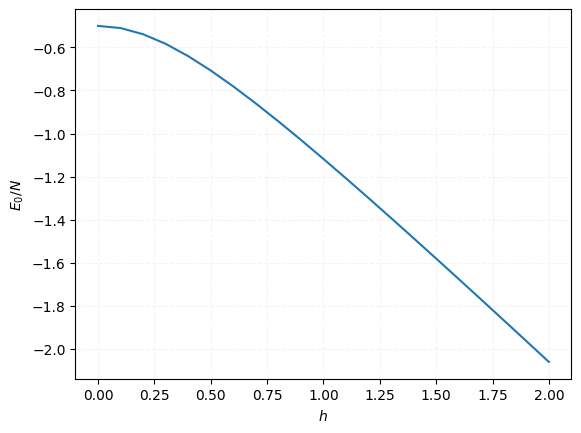

In [8]:
# Plot the ground state energy per spin as a function of h for an interval of h = [0,2]
hs = np.linspace(0, 2, 21)
E0_array = [] # initialization
for h in hs:
  H_h = TFIM_two_spin_hamiltonian(h)
  energies, eigenstates = np.linalg.eigh(H_h)
  E0_array.append(energies[0])

E0_array = np.array(E0_array)

import matplotlib.pyplot as plt
plt.plot(hs, E0_array/2) # energy per spin
plt.xlabel('$h$')
plt.ylabel('$E_0/N$')
plt.grid(True, alpha=0.15, ls='--')

###Part 4(c) Calculate and plot total magnetization per spin as a function of $h$ ###

In [ ]:
# Plot the expectation value of the total magnetization sigma^z_1 + sigma^z_2
# (per spin) measured on the ground state as a function of h, for an interval
# of h = [0,2]
m_tot = np.kron(s_z,np.eye(2)) + np.kron(np.eye(2),s_z)
m_tot_array = [] # initialization

hs = np.linspace(0,2,1000)
for h in hs:
  H_h = TFIM_two_spin_hamiltonian(h)
  energies, eigenstates = np.linalg.eigh(H_h)
  m_tot_h = np.einsum('i,ij,j->',eigenstates[:,0],m_tot,eigenstates[:,0]).real
  #m_tot_h_2 = np.dot(eigenstates[:,0].conj().T, m_tot.dot(eigenstates[:,0])).real
  #assert np.allclose(m_tot_h,m_tot_h_2)
  m_tot_array.append(m_tot_h)

m_tot_array = np.array(m_tot_array)

import matplotlib.pyplot as plt
plt.plot(hs, m_tot_array/2) # energy per spin
plt.xlabel('$h$')
plt.ylabel('$m/N$')
plt.grid(True, alpha=0.15, ls='--')

Note that the plot, if done correctly, will show that the magnetization vanishes at all $h$ except at $h=0$. Now it is well-known that in the thermodynamic limit ($N\rightarrow \infty$), there is a quantum critical point in the 1D transverse-field Ising model at $h/J=1$, separating a symmetry-broken ordered phase with nonzero magnetization from a disordered (zero magnetization) phase. In finite systems (i.e. finite $N$), however, exact diagonalization (ED) at finite $h$ always finds a ground state that is a superposition of configurations in such a way that the magnetization vanishes, even below $h/J = 1$, which represents the ordered regime where you would expect to see nonzero magnetization in the limit $N\rightarrow \infty$. What ED does in this case of finite $N$ is find a ground state that is a superposition of the two ground states corresponding to the two symmetry-broken regimes in the interval $h/J \in [0,1]$.  Eventually, if $h$ is small enough ($\sim 0$), ED will no longer find this superposition, but instead it will "choose" either the all up-state or the all-down state as the ground state, even though there is effectively a degeneracy. In the thermodynamic limit, if $h/J < 1$, the true physics of the system is such that the system "chooses" one of the two symmetry broken regimes (based on "past history" of the system and its initial conditions in nature) and spontaneous nonzero magnetization appears, since the other symmetry broken regime (all spins flipped) cannot be reached in finite time by local fluctuations (individual spin flips) due to the infinite number of spins present in the system. But for finite systems, unless $h/J \sim 0$, ED will always find superpositions of both symmetry-broken regimes, hence why the magnetization vanishes.

###Part 4(d) Dynamics 1: Prepare the system in the ground state of a Hamiltonian ###

In [ ]:
# Dynamics: Time evolution after a quantum quench
# (1) Prepare the system in the ground state of a Hamiltonian with h = 0 (classical Ising model), defining an initial state psi_0
H_classical_ising = TFIM_two_spin_hamiltonian(0)
energies, eigenstates = np.linalg.eigh(H_classical_ising)
psi_0 = eigenstates[:,0]

###Part 4(d) Dynamics 2: Time evolution after a quantum quench ###

In [ ]:
# (2) Time evolve the state according using the critical TFIM Hamiltonian (h = 1) (this is the quantum quench)
# You can just re-define the evolve() function in this block of code:
def evolve(state, t):
    return scipy.linalg.expm(-1.0j * H_critical * t).dot(state)

### Part 4(d) Dynamics 3: Plot total magnetization as a function of time ###

In [ ]:
# (3) Calculate and plot total magnetization per spin as a function of time
m_tot_t_array = []
ts = np.linspace(0, 10, 1000)
for t in ts:
  psi_t = evolve(psi_0, t)
  m_tot_t = np.dot(psi_t.conj().T, m_tot.dot(psi_t))
  m_tot_t_array.append(m_tot_t)

m_tot_t_array = np.array(m_tot_t_array)

import matplotlib.pyplot as plt
plt.plot(ts, m_tot_t_array/2) # energy per spin
plt.xlabel('$h$')
plt.ylabel(r'$\frac{m(t)}{N}$',rotation = 0, labelpad = 30)
plt.grid(True, alpha=0.15, ls='--')

### Part 4(d) Dynamics 4: Plot energy as a function of time

In [ ]:
# (4) Plot energy per spin vs time to prove energy is conserved
E_t_array = []
ts = np.linspace(0,100,2000)
for t in ts:
  psi_t = evolve(psi_0, t)
  E_t = m_tot_t = np.dot(psi_t.conj().T, H_critical.dot(psi_t)).real
  E_t_array.append(E_t)

E_t_array = np.array(E_t_array)

import matplotlib.pyplot as plt
plt.plot(ts, E_t_array/2) # energy per spin
plt.xlabel('$h$')
plt.ylabel(r'$\frac{\langle \hat H \rangle_t}{N}$',rotation = 0, labelpad = 30)
plt.grid(True, alpha=0.15, ls='--')

Note: in practice, using the methods at hand, if you time-evolve for long enough, does the energy stay constant? Why or why not?

**It should stay constant- but because of numerical precision issues associated with the implementation of the supposedly exact time evolution, it does not. In essence, using the matrix exponential technique scipy.linalg.expm is clearly not exact- there is usually no way to calculate the exponential of a matrix exactly.**